## Objectif
Comme dans le projet fil rouge, les données que l'on utilise sur les offres d'emplois sont trop predictible, on a jugé nécéssaire de tester nos algorithmes sur des données un peut plus brut et non propres qui sont les twittes. En effet, les twittes n'ont pas de structure rédactionnelles bien défini et propre,et que pour une thématique les gens sont libres de dire ce qu'ils veulent, on a alors plus de complication niveau prédiction. 

Nous allons aussi dans cette partie, développer une classe qui va nous permettre de plonger dans une espace de matrice notre corpus avec le word2vec. 

In [1]:
import numpy as np
from sklearn.datasets import load_digits
import gensim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import pandas as pd
from textblob import Word
from sklearn.pipeline import Pipeline
import multiprocessing
import tqdm
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import nltk
import json
import ast
import string
import regex
import re
from pandas.io.json import json_normalize
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
%matplotlib notebook
plt.style.use("ggplot")

In [2]:
def read_json(df_path):
    f=open(df_path,"r")
    df=[]
    for x in f:
        df.append(ast.literal_eval(x.replace("\n","")))
    return(pd.DataFrame(df))

In [3]:
train=read_json("/home/tantely/Documents/INSA_Rouen/cours-insa/CalculDistribue/train.json")
test=read_json("/home/tantely/Documents/INSA_Rouen/cours-insa/CalculDistribue/test.json")
noclass=read_json("/home/tantely/Documents/INSA_Rouen/cours-insa/CalculDistribue/noclass.json")

In [4]:

def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [5]:
def nettoyage_donnee(df,language_stopword="english"):
    
    rm_ponct = str.maketrans('','',string.punctuation)
    df.message = df.message.apply(lambda x:x.translate(rm_ponct))
    df.message = df.message.apply(lambda x:x.encode("ascii","ignore").decode("utf-8"))
    df.message = df.message.apply(lambda x:re.sub(r'https\S+',"",x))
    stop_en = stopwords.words(language_stopword)
    df.message = df.message.apply(lambda x:" ".join(x.lower() for x in np.str(x).split() if x.lower() not in stop_en))
    df.message = df.message.apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
    
    return df

In [6]:
X_a=nettoyage_donnee(train,language_stopword="french")
X_t=nettoyage_donnee(test,language_stopword="french")
X_c=nettoyage_donnee(noclass,language_stopword="french")

## word2vec:

In [7]:
reclean_text=[]
for x in X_a.iloc[:,0]:
    reclean_text.append(gensim.utils.simple_preprocess(x))
model=gensim.models.Word2Vec(reclean_text,size=300,window=10,min_count=2,workers=10)

In [8]:
model.wv.similar_by_word('theory')

[('computer', 0.9362990856170654),
 ('brock', 0.919305682182312),
 ('ts', 0.9139494895935059),
 ('cense', 0.9127687215805054),
 ('bouclier', 0.9044535160064697),
 ('grrrrrrrr', 0.900521993637085),
 ('devait', 0.8997613191604614),
 ('dickhead', 0.897070050239563),
 ('essayions', 0.8968344330787659),
 ('spn', 0.8962534666061401)]

In [9]:
model.wv.most_similar("theory")

[('computer', 0.9362990856170654),
 ('brock', 0.919305682182312),
 ('ts', 0.9139494895935059),
 ('cense', 0.9127687215805054),
 ('bouclier', 0.9044535160064697),
 ('grrrrrrrr', 0.900521993637085),
 ('devait', 0.8997613191604614),
 ('dickhead', 0.897070050239563),
 ('essayions', 0.8968344330787659),
 ('spn', 0.8962534666061401)]

In [10]:
model["theory"]

/home/tantely/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 9.85756610e-03,  2.65546441e-02,  1.91276819e-02, -1.15926089e-02,
        1.18823051e-02, -8.63853726e-04, -1.27987536e-02, -6.42386079e-03,
        5.47113828e-03,  2.04200801e-02, -1.61705744e-02,  4.19208640e-03,
       -1.34784458e-02, -7.88000599e-03, -1.99810285e-02, -1.27187534e-03,
        6.91953674e-03, -2.09671091e-02,  2.50525810e-02,  8.91386718e-03,
       -1.76645089e-02,  2.74164695e-02,  3.49608669e-03, -1.97091904e-02,
       -4.25866991e-03,  1.52590941e-03,  8.83322675e-03, -2.00098492e-02,
        2.46207062e-02,  1.11577529e-02, -6.64992630e-03,  1.37655437e-02,
        1.19281840e-03,  1.25360372e-03, -1.85304889e-04,  5.42590395e-03,
       -1.29798595e-02, -6.95557380e-03,  2.08781939e-02, -3.01182345e-02,
       -4.27407725e-03, -1.07173445e-02, -1.63298263e-03,  2.67569050e-02,
        1.97887467e-03,  1.51261268e-02, -3.13901566e-02,  3.96664022e-03,
        2.05889437e-02, -2.69743055e-03, -8.78181867e-03, -2.25659274e-02,
       -1.59820300e-02,  

/home/tantely/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/home/tantely/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/tantely/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


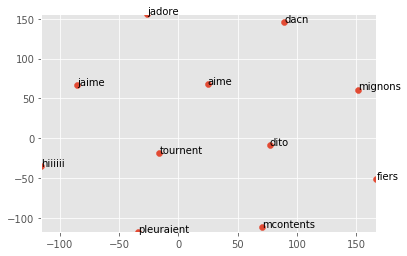

In [11]:
display_closestwords_tsnescatterplot(model, 'aime')

## Classification des mots:
Transformation des mots avec le TF-IDF

In [12]:
Xa,y_train=X_a.message,X_a.polarity
Xt,y_test=X_t.message,X_t.polarity

In [13]:
vct=TfidfVectorizer()
trsfm=vct.fit(Xa)
Xtrain=trsfm.transform(Xa)
Xtest=trsfm.transform(Xt)

In [14]:
mlSVM=LinearSVC()
mlSVM.fit(Xtrain,y_train)
mlSVM.score(Xtest,y_test)

0.7672194791490249

On va maintenant essayer d'améliorer le modèle en essayant de rechcher le meilleur paramètre C du modèle SVM.

In [15]:
x_train,x_val,ytrain,yval=train_test_split(Xtrain,y_train)

/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C optimal = 0.13894954943731375


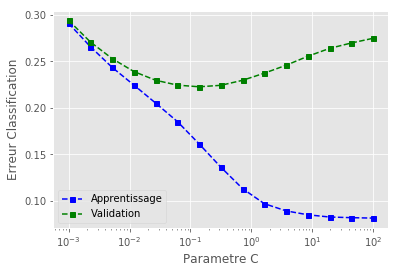

In [16]:
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
clf_svm=LinearSVC(C=1)
for ind_C, C in enumerate(vectC):
    clf_svm.C = C
    clf_svm.fit(x_train, ytrain)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(yval, clf_svm.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(ytrain, clf_svm.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

On remarque que l'on a un sur-apprentissage lorsque la valeur de C commence à dépasser les 0.1. Donc si l'on veut eviter le sur-apprentissage on doit prendre comme valeur de C une valeur inférieur à 0.1. Dans notre cas, on a comme valeur optimal de C 0.13, donc on va prendre comme valeur de C pour éviter le sur-apprentissage égale è 0.061.

Maintenant, calculons le score sur les données test avec cette valeur de C.

In [17]:
vectC=0.061
clf_svm=LinearSVC(C=vectC)
clf_svm.fit(Xtrain,y_train)
print("Le score={}",clf_svm.score(Xtest,y_test))

Le score={} 0.7757657082557095


## Regression logistique:

/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 C optimal = 1.6378937069540647


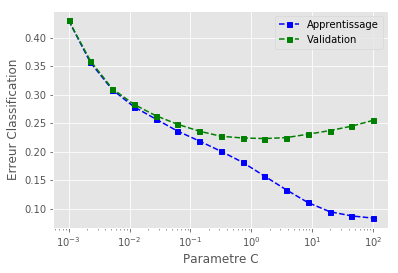

In [18]:
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
clf_svm=LogisticRegression(C=1)
for ind_C, C in enumerate(vectC):
    clf_svm.C = C
    clf_svm.fit(x_train, ytrain)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(yval, clf_svm.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(ytrain, clf_svm.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [19]:
clf_svm=LogisticRegression(C=1)

In [20]:
print(Copt)
vectC

1.6378937069540647


array([  0.001     ,   0.00227585,   0.00517947,   0.01178769,
         0.02682696,   0.06105402,   0.13894955,   0.31622777,
         0.71968567,   1.63789371,   3.72759372,   8.48342898,
        19.30697729,  43.93970561, 100.        ])

Encore une fois, pour éviter la sur-apprentissage, on va prendre une valeur de C qui sera égale à 0.1394.

In [22]:
vectC=0.13894955
clf_svm=LogisticRegression(C=vectC)
clf_svm.fit(Xtrain,y_train)
print("Le score={}".format(clf_svm.score(Xtest,y_test)))

Le score=0.7656822001328835


## Classe skip-gram moyenne:
Cette class a pour objectif de transformer les corpus en une matrice numérique avec le skyp-gram de word2vec. La méthode n'est pas encore fiable lorsqu'on a des mots que l'on ne peut traiter par les méhodes de normalisation standard. Par exemple dans des twittes, les gens utilisent un seul mot qui n'a pas trop de sens si on veut faire des transformations numériques. 

In [24]:
from Word2VecTransformer import Embedding_skipGram

In [25]:
emb_train=Embedding_skipGram(n_size=150,n_window=10,n_min_count=2,n_workers=10)

In [26]:
emb_train.fit(train.message)
#isinstance(train.message,pd.Series)

In [27]:
X_embed_W2V=emb_train.transform(train.message)

In [28]:
X_test_embed_W2V=emb_train.transform(test.message)

In [29]:
print(X_test_embed_W2V.shape)
print(X_embed_W2V.shape)
print(len(train.polarity))

(76759, 150)
(128401, 150)
128401


In [30]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X_embed_W2V)

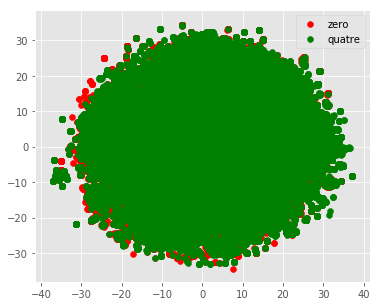

In [31]:
plt.figure(figsize=(6, 5))
label_name="zero","quatre"
target_ids=np.unique(train.polarity)
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'

for i, c, label in zip(target_ids, colors, label_name):
    plt.scatter(X_2d[train.polarity == i, 0], X_2d[train.polarity == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [57]:
X_2d

array([[  6.000753, -25.25286 ],
       [ -7.642609, -29.628395],
       [-14.850317,  13.406377],
       ...,
       [ -7.160858, -32.45229 ],
       [ 18.861605,  31.711937],
       [ 24.001045,  28.335836]], dtype=float32)

/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C optimal = 3.7275937203149416


<IPython.core.display.Javascript object>


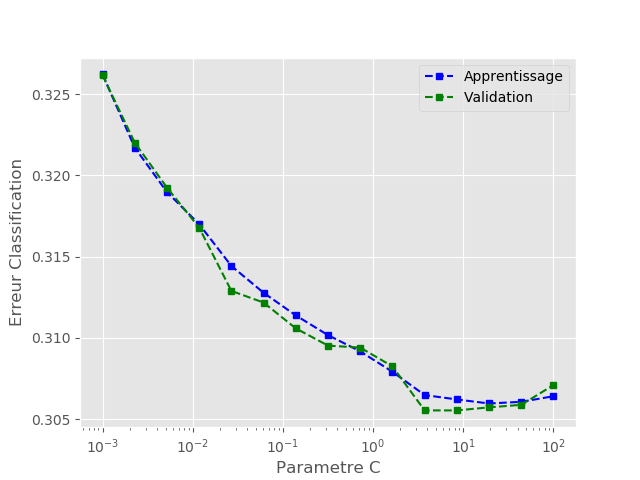

In [61]:
x_train,x_val,ytrain,yval=train_test_split(X_embed_W2V,y_train)
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
clf_svm=LinearSVC(C=1)
for ind_C, C in enumerate(vectC):
    clf_svm.C = C
    clf_svm.fit(x_train, ytrain)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(yval, clf_svm.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(ytrain, clf_svm.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [63]:
vectC=Copt
clf_svm=LinearSVC(C=vectC)
clf_svm.fit(X_embed_W2V,y_train)
print("Le score={}",clf_svm.score(X_test_embed_W2V,y_test))

Le score={} 0.6956057270157245


## Doc2 vec

In [69]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result
  
all_x = pd.concat([train.message,test.message])
all_x_w2v = labelize_tweets_ug(all_x, 'all')


cores = multiprocessing.cpu_count()
model_ug_dbow = gensim.models.Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha


/home/tantely/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  if sys.path[0] == '':
/home/tantely/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:580: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 205160/205160 [00:00<00:00, 3453132.72it/s]


In [72]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha
   

100%|██████████| 205160/205160 [00:00<00:00, 3495168.15it/s]


In [105]:
def get_vector(model,corpus,size):
    vecs=np.zeros((corpus.shape[0],size))
    n=0
    for i in range(corpus.shape[0]):
        prefix="all_"+str(i)
        vecs[n]=model.docvecs[prefix]
        n+=1
    return vecs

In [112]:
train_vecs_dmc = get_vector(model_ug_dmc, train.message, 100)
test_vecs_dmc = get_vector(model_ug_dmc, test.message, 100)

/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number o


 C optimal = 19.306977288832496


<IPython.core.display.Javascript object>


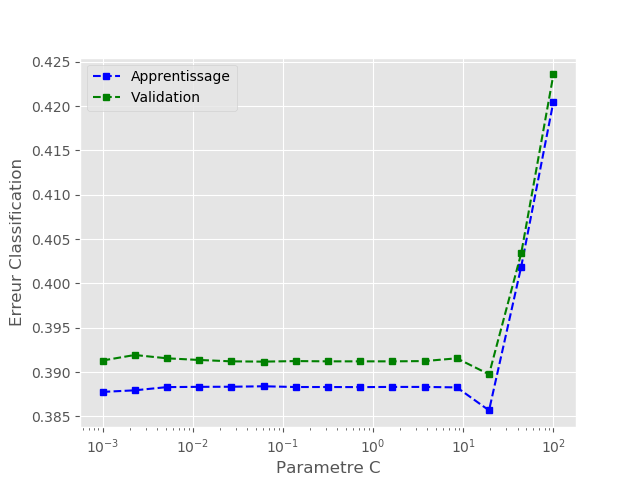

In [113]:
x_train,x_val,ytrain,yval=train_test_split(train_vecs_dmc,y_train)
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
clf_svm=LinearSVC(C=1)
for ind_C, C in enumerate(vectC):
    clf_svm.C = C
    clf_svm.fit(x_train, ytrain)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(yval, clf_svm.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(ytrain, clf_svm.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

On constate que l'on a pas de sur-apprentissage dans notre modèle.

In [114]:
vectC=Copt
clf_svm=LinearSVC(C=vectC)
clf_svm.fit(train_vecs_dmc,y_train)
print("Le score={}",clf_svm.score(test_vecs_dmc ,y_test))

Le score={} 0.5932985057126852


/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to '


 C optimal = 0.001


<IPython.core.display.Javascript object>


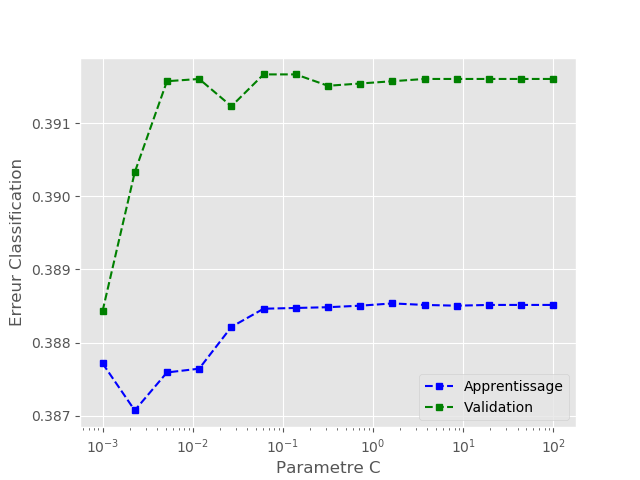

In [115]:
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
clf_svm=LogisticRegression(C=1)
for ind_C, C in enumerate(vectC):
    clf_svm.C = C
    clf_svm.fit(x_train, ytrain)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(yval, clf_svm.predict(x_val))
    err_app[ind_C] = 1 - accuracy_score(ytrain, clf_svm.predict(x_train))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [116]:
vectC=Copt
clf_svm=LogisticRegression(C=vectC)
clf_svm.fit(Xtrain,y_train)
print("Le score={}",clf_svm.score(Xtest,y_test))

/home/tantely/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Le score={} 0.592581977357704


##  Deep learning:

In [13]:
from keras.models import Sequential,layers
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(100, 10, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(11, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

ModuleNotFoundError: No module named 'keras'

In [122]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.message)
Xa,Xv,ya,yv=train_test_split(train.message,train.polarity)
X_train_keras = tokenizer.texts_to_sequences(Xa)
X_test_keras = tokenizer.texts_to_sequences(test.message)
X_val_keras = tokenizer.texts_to_sequences(Xv)
 # Adding 1 because of reserved 0 index

tab=[]
for i,k in enumerate(train.message):
    tab.append(len(k.split(" ")))

In [123]:
vocab_size=len(tokenizer.word_index)+1

In [124]:
from keras.preprocessing.sequence import pad_sequences

maxlen = np.max(tab)

X_train_keras1 = pad_sequences(X_train_keras, padding='post', maxlen=maxlen)
X_test_keras1 = pad_sequences(X_test_keras, padding='post', maxlen=maxlen)


In [126]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
le =LabelEncoder()
le.fit(y_train)
Ya=to_categorical(le.transform(ya))
Yt=to_categorical(le.transform(y_test))
Yv=to_categorical(le.transform(yv))

In [129]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 38, 50)            3191800   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1900)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                19010     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total params: 3,210,832
Trainable params: 3,210,832
Non-trainable params: 0
_________________________________________________________________


In [130]:
history = model.fit(X_train_keras1, Ya,epochs=10,verbose=False,validation_split=0.25,batch_size=10)

Instructions for updating:
Use tf.cast instead.


In [131]:
loss, accuracy = model.evaluate(X_train_keras1, Ya, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_keras1, Yt, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9221
Testing Accuracy:  0.7081


In [132]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [24]:
np.array([1.5,1.2,2.2,2.1]).mean(axis=0)

1.75